# Kagge Mobile Net Using Stroke Data


In [10]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
#import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from random import randint
import pandas as pd
import pickle
import ast
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from keras.models import load_model

In [11]:
f = open("/data/miniclasses.txt","r")
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]
n = len(classes)
print('no', n)
vals = [x for x in range(0,n)]
classmap = dict(zip(classes, vals))
classmaprev = dict(zip(vals,classes))

no 340


In [12]:
all_files = glob.glob(os.path.join('shuffledtrain2/', '*.csv'))
batchsize =  530
img_size = 80
N_CLASSES = 340
STEPS = 1000
EPOCHS = 15
size = 80
TEST_DIR = ''
N_FILES = 100

In [13]:
print(all_files)
t = pd.read_csv(all_files[1], nrows = 10)
t['drawing'] = t['drawing'].apply(ast.literal_eval)
labels = t['word']
labels = [c.replace(' ','_') for c in labels]
idx = [classmap[x] for x in labels]
print(idx)

[]


IndexError: list index out of range

In [6]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((256, 256), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != 256:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def image_generator_xd(all_files,classmap, size, batchsize,ks,N_CLASSES, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = all_files[k]
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                y = np.empty([0])
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                labels = df['word']
                labels = [c.replace(' ','_') for c in labels]
                idx = [classmap[x] for x in labels]
#                 path, _ = filename.split('.csv')
#                 _, classname = path.split('/')
#                 classname = classname.replace(' ','_')
#                 idx = classmap[classname]
#                 labels = np.full(len(df), idx)
                y = np.append(y, idx)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(y, N_CLASSES)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

In [7]:
train_datagen = image_generator_xd(all_files,classmap,size=img_size, N_CLASSES= N_CLASSES,batchsize=batchsize,ks=range(N_FILES))

In [8]:
x, y= next(train_datagen)
print(x.shape)
print(y.shape)

IndexError: list index out of range

(530, 80, 80, 1)
(530, 340)
printing


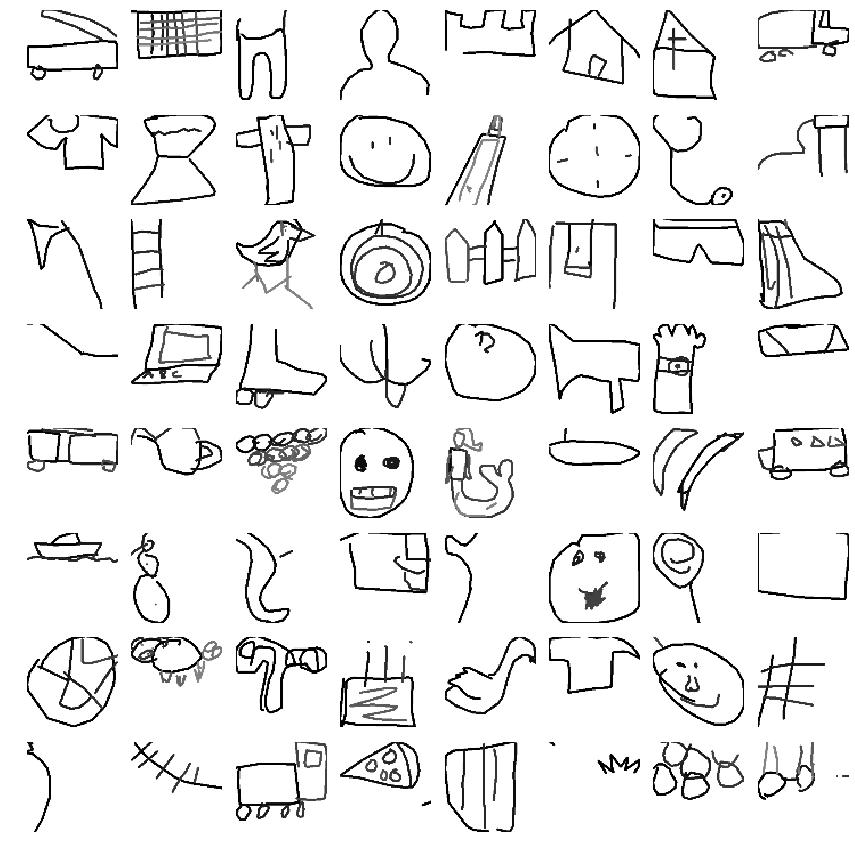

In [26]:
x, y  = next(train_datagen)
print(x.shape)
print(y.shape)
n = 8
print('printing')
%matplotlib inline
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
#fig.savefig('gs.png', dpi=300)
plt.show()
# print(lab)


In [27]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=N_CLASSES)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80, 80, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 81, 81, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)        128       
__________

In [28]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/15
1000/1000 [==============================] - 559s 559ms/step - loss: 2.5565 - categorical_crossentropy: 2.5565 - categorical_accuracy: 0.4213 - top_3_accuracy: 0.6092
Epoch 2/15
1000/1000 [==============================] - 542s 542ms/step - loss: 1.4943 - categorical_crossentropy: 1.4943 - categorical_accuracy: 0.6251 - top_3_accuracy: 0.8143
Epoch 3/15
1000/1000 [==============================] - 541s 541ms/step - loss: 1.2515 - categorical_crossentropy: 1.2515 - categorical_accuracy: 0.6798 - top_3_accuracy: 0.8537
Epoch 4/15
1000/1000 [==============================] - 542s 542ms/step - loss: 1.1032 - categorical_crossentropy: 1.1032 - categorical_accuracy: 0.7128 - top_3_accuracy: 0.8760
Epoch 5/15
1000/1000 [==============================] - 542s 542ms/step - loss: 0.9852 - categorical_crossentropy: 0.9852 - categorical_accuracy: 0.7397 - top_3_accuracy: 0.8932
Epoch 6/15
1000/1000 [==============================] - 541s 541ms/step - loss: 0.8821 - categorical_crossentr

# Checking

printing


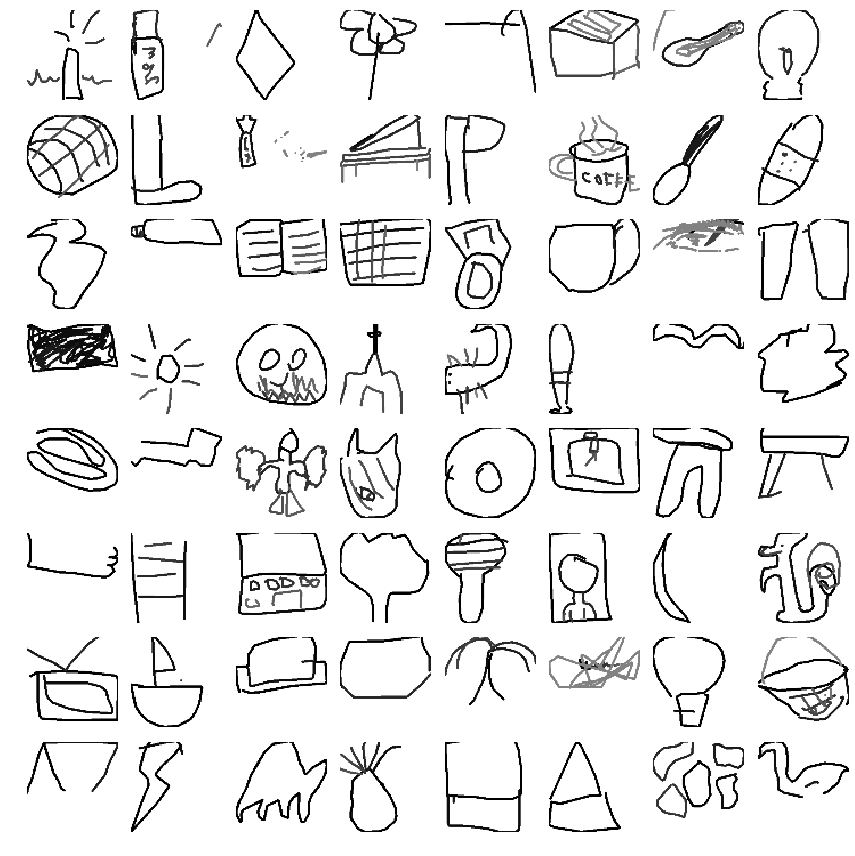

In [29]:
x,y  = next(train_datagen)
train_pred = model.predict(x)
n = 8
print('printing')
%matplotlib inline
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
# fig.savefig('gs.png', dpi=300)
plt.show()
# print(lab)

In [30]:
print(train_pred[0:2,0:4])

[[7.3674784e-08 1.1723841e-05 3.1785508e-09 1.4744248e-08]
 [1.4841932e-10 3.7176731e-09 9.2613753e-08 7.5260775e-10]]


In [31]:
top3 = preds2catids(train_pred)
top3.head()
top3.shape
top3cats = top3.replace(classmaprev)
print(top3cats.head())
top3cats.shape

              a             b           c
0       lantern    lighthouse      candle
1     telephone        marker  cell_phone
2       diamond       hexagon  lighthouse
3        flower        grapes      garden
4  diving_board  fire_hydrant  toothbrush


(530, 3)

# Submission

In [36]:
test = pd.read_csv('test_simplified.csv')
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

(112199, 3) (112199, 80, 80, 1)
Test array memory 2.68 GB


In [37]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)
top3 = preds2catids(test_predictions)
top3.head()
top3.shape

112199/112199 [==============================] - 24s 210us/step


(112199, 3)

In [38]:
#cats = list_all_categories()
# id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(classmaprev)
print(top3cats.head())
top3cats.shape

                         a            b          c
0                    radio       stereo    snorkel
1                     belt  hockey_puck  bottlecap
2  The_Great_Wall_of_China       castle      crown
3                 mountain       ladder      crown
4                fireplace        crown      canoe


(112199, 3)

In [39]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_test_m.csv', index=False)
submission.head()
submission.shape

(112199, 2)